# VPG
Based on Miguels Vanilla Policy Gradient (aka REINFORCE with baseline)
- Ues action-advantage function
- uses entropy to encourage more even distribution and encourage exploration 

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions.categorical import Categorical
import numpy as np
import gymnasium as gym
from gymnasium.spaces import Discrete, Box
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
# CUDA for 500 episodes: 60 - 80 seconds 
# CPU for 500 episodes: ~30 seconds
# for small workloads CPU only will be faster
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = "cpu"
print("using", device)
# !nvidia-smi

using cuda


In [3]:
class SimpleModel(nn.Module):

    def __init__(self, in_features, outputs):
        super(SimpleModel, self).__init__()
        self.linear1 = nn.Linear(in_features, 32)
        self.linear2 = nn.Linear(32, 32)
        self.final = nn.Linear(32, outputs)
        self.device = torch.device(device)
        self.to(self.device)

    def _format(self, state):
        x = state
        if not isinstance(x, torch.Tensor):
            x = torch.tensor(x,
                             device=self.device,
                             dtype=torch.float32)
            x = x.unsqueeze(0)
        return x

    def forward(self, x):
        x = self._format(x)
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        x = self.final(x)
        return x

In [4]:
env = gym.make("CartPole-v1")
n_states = env.observation_space.shape[0]
n_action = env.action_space.n
print("action space:", env.action_space)
print("observation space:", env.observation_space)
observation, info = env.reset(seed=42)
print("observation:", observation)
print("info", info)
policy_model = SimpleModel(n_states, n_action)
value_model = SimpleModel(n_states, 1)
value_model

action space: Discrete(2)
observation space: Box([-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38], (4,), float32)
observation: [ 0.0273956  -0.00611216  0.03585979  0.0197368 ]
info {}


SimpleModel(
  (linear1): Linear(in_features=4, out_features=32, bias=True)
  (linear2): Linear(in_features=32, out_features=32, bias=True)
  (final): Linear(in_features=32, out_features=1, bias=True)
)

In [5]:
n_episodes = 500
reward_record = []
avg_record = []
learning_rate = 0.001
gamma=0.99
solved = False
policy_optimizer = torch.optim.Adam(policy_model.parameters(), lr=learning_rate)
value_optimizer = torch.optim.Adam(value_model.parameters(), lr=learning_rate)
for episode in tqdm(range(n_episodes)):
    state, info = env.reset()
    terminated = False
    truncated = False
    episode_rewards = []
    episode_log_p_a = []
    episode_entropy = []
    episode_values = []
    if solved:
        print("solved!")
    while not (terminated or truncated):
        # execute episode
        logits = policy_model.forward(state)
        value = value_model.forward(state)
        policy = torch.distributions.Categorical(logits=logits)
        action_tensor = policy.sample()
        log_prob_action = policy.log_prob(action_tensor)
        episode_log_p_a.append(log_prob_action)
        episode_entropy.append(policy.entropy())
        episode_values.append(value)
        state, reward, terminated, truncated, info = env.step(action_tensor.item())
        episode_rewards.append(reward)
        
    # calculate loss
    T = len(episode_rewards)
    discount_vector = np.logspace(0, T, num=T, base=gamma, endpoint=False)
    returns = []
    for t in range(T):
        returns.append(np.sum(discount_vector[:(T-t)] * episode_rewards[t:]))
    episode_log_p_a = torch.cat(episode_log_p_a)
    values = torch.cat(episode_values).to(device)
    returns = torch.tensor(returns).to(device)
    entropies = torch.tensor(episode_entropy).to(device)
    discount_vector = torch.tensor(discount_vector).to(device)
    
    # optimize
    value_error = returns - values
    # multiply by discount optional
    policy_loss = -(episode_log_p_a * value_error.detach() * discount_vector).mean()
    entropy_loss = -entropies.mean()
    loss = policy_loss + entropy_loss
    policy_optimizer.zero_grad()
    loss.backward()
    policy_optimizer.step()
    value_loss = value_error.pow(2).mul(0.5).mean()
    value_optimizer.zero_grad()
    value_loss.backward()
    value_optimizer.step()
    # print(f"episode: {episode}, loss: {loss.item():4.3f}, reward: {np.sum(episode_rewards)}")
    reward_record.append(np.sum(episode_rewards))
    rolling_average = np.mean(reward_record[-100:])
    avg_record.append(rolling_average)

100%|██████████| 500/500 [01:04<00:00,  7.74it/s]


In [6]:
# CUDA for 500 episodes: 60 - 80 seconds 
# CPU for 500 episodes: ~30 seconds

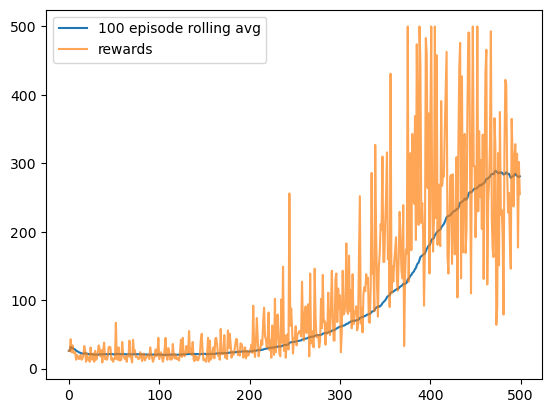

In [7]:
plt.plot(avg_record, label='100 episode rolling avg')
plt.plot(reward_record, alpha=0.7, label='rewards')
plt.legend()

In [54]:
# evaluate
env = gym.make('CartPole-v1', render_mode="human")
state, info = env.reset()
policy_model.eval()
for _ in range(3):
    terminated, truncated = False, False
    while not (terminated or truncated):
        logits = policy_model.forward(state)
        # policy = torch.distributions.Categorical(logits=logits)
        # action_tensor = policy.sample()
        greedy_action = torch.argmax(logits)
        state, reward, terminated, truncated, info = env.step(greedy_action.item())
    observation, info = env.reset()

env.close()